In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
import seaborn as sn
from sklearn.ensemble import RandomForestClassifier
import math
import warnings
warnings.filterwarnings('ignore')

In [45]:
df=pd.read_csv('Fatal_Police_Shootings_in_the_US.csv')
df.head(5)

,id,name,date,manner_of_death,armed,age,gender,race,city,state,...,flee,body_camera,Median Income,poverty_rate,percent_completed_hs,share_white,share_black,share_native_american,share_asian,share_hispanic
0,3,Tim Elliot,02/01/15,shot,gun,53.0,M,A,Shelton,WA,...,Not fleeing,False,37072.0,28.6,80.1,78.9,0.8,3.7,1.1,19.2
1,4,Lewis Lee Lembke,02/01/15,shot,gun,47.0,M,W,Aloha,OR,...,Not fleeing,False,65765.0,14.9,88.1,70.9,2.6,1.0,8.9,21.1
2,890,Phyllis Ilene Jepsen,02/10/15,shot,knife,55.0,F,W,Aloha,OR,...,Not fleeing,False,65765.0,14.9,88.1,70.9,2.6,1.0,8.9,21.1
3,5,John Paul Quintero,03/01/15,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,...,Not fleeing,False,45947.0,17.3,87.5,71.9,11.5,1.2,4.8,15.3
4,765,Nicholas Garner,22/08/15,shot,vehicle,26.0,M,W,Wichita,KS,...,Car,False,45947.0,17.3,87.5,71.9,11.5,1.2,4.8,15.3


In [10]:
def preprocessing(df):
    df = df.drop(['id', 'name', 'state', 'city', 'body_camera', 'flee','armed'], axis=1) #'armed'

    l_ch = []
    for e in df['threat_level']:
        if e == 'undetermined':
            l_ch.append('threat_level_undetermined')
        else:
            l_ch.append(e)
    df['threat_level'] = l_ch

    df = df[df['race'].notna()]
#     df = df[df['armed'].notna()]
    df = df.reset_index(drop=True)

    df['age'] = df['age'].fillna(df['age'].median())
    df['Median Income'] = df['Median Income'].fillna(df['Median Income'].median())
    cols = [ 'threat_level', 'manner_of_death', 'gender'] #'armed'
    for col in cols:
        dummy = pd.get_dummies(df[col])
        df = pd.concat([df, dummy], axis=1)
        df = df.drop(col,axis=1)
    df['signs_of_mental_illness'] = df['signs_of_mental_illness'].astype(int)
    ll =[datetime.strptime(element, '%d/%m/%y') for element in df['date']]
    ll2 = [e.strftime('%Y-%m-%d %H:%M:%S.%f') for e in ll]
    ll3 =[datetime.fromisoformat(element).timestamp() for element in ll2]
    df['date'] = ll3
    l_race  = []
    for e in df['race']:
        if e == 'W':
            l_race.append(1)
        else:
            l_race.append(0)
    df['race'] = l_race
    return df
def weightedMean(Y,W,n) :
    sum = 0
    numWeight = 0
    i = 0
    while  i < n :     
        numWeight = numWeight + Y[i] * W[i]
        sum = sum + W[i]
        i = i + 1
    return round((numWeight / sum),4)
df=pd.read_csv('Fatal_Police_Shootings_in_the_US.csv')
preprocessing(df).head()

,date,age,race,signs_of_mental_illness,Median Income,poverty_rate,percent_completed_hs,share_white,share_black,share_native_american,share_asian,share_hispanic,attack,other,threat_level_undetermined,shot,shot and Tasered,F,M
0,1.420153e+09,53.0,0,1,37072.0,28.6,80.1,78.9,0.8,3.7,1.1,19.2,1,0,0,1,0,0,1
1,1.420153e+09,47.0,1,0,65765.0,14.9,88.1,70.9,2.6,1.0,8.9,21.1,1,0,0,1,0,0,1
2,1.443737e+09,55.0,1,1,65765.0,14.9,88.1,70.9,2.6,1.0,8.9,21.1,0,1,0,1,0,1,0
3,1.420240e+09,23.0,0,0,45947.0,17.3,87.5,71.9,11.5,1.2,4.8,15.3,0,1,0,0,1,0,1
4,1.440194e+09,26.0,1,0,45947.0,17.3,87.5,71.9,11.5,1.2,4.8,15.3,1,0,0,1,0,0,1


<AxesSubplot:>

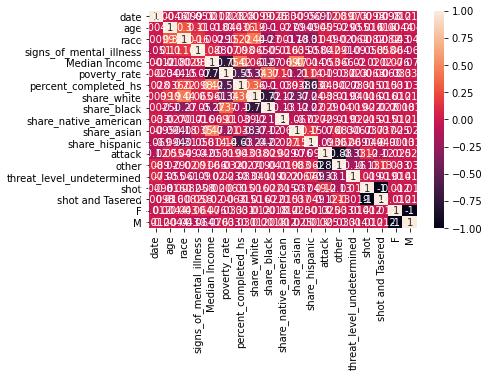

In [4]:
corr_matrix=preprocessing(df).corr()
sn.heatmap(corr_matrix, annot=True)

In [29]:
def losowa_nielosowa_split(df,i, losowa_wielkosc = 400):
  df_nielosowa = df[0+i:losowa_wielkosc+i]
  df_nielosowa = df_nielosowa.reset_index(drop=True)
  #Sprawdzanie ile wartosci znajduje się w populacji i ile chcemy przypisać do zbioru losowego
  import math
  dict_len = {}
  for e in df['state'].unique():
    lenn = math.ceil(len(df[df['state'] == e])/len(df)*losowa_wielkosc)
    dict_len[e] = lenn
  #obliczanie probability
  dict_prob = {}
  for e in dict_len.keys():
    prob = dict_len[e]/len(df[df['state'] == e])
    dict_prob[e] = prob
  #obliczanie wag
  dict_waga ={}
  for e in dict_prob.keys():
    waga = 1/dict_prob[e]
    dict_waga[e] = waga
  #tworzenie proby losowej
  proba_losowa = pd.DataFrame()
  for element in dict_len.keys():
    t = df[df['state'] == element].sample(n=int(dict_len[element]), replace=False, random_state = i)
    proba_losowa = pd.concat([proba_losowa, t])
  #dodawanie wag do proby losowej
  ll_wagi = []
  for e in proba_losowa['state']:
    waga = dict_waga[e]
    ll_wagi.append(waga)
  proba_losowa['waga'] = ll_wagi
  return proba_losowa, df_nielosowa

In [30]:
Srednie_wazone_PSW=[]
Srednie_wazone_naiwny=[]
for i in range(100):
    #tworzymy próby losowe i nielosowe
    df_losowa, df_nielosowa=losowa_nielosowa_split(df,i)
    df_nielosowa=preprocessing(df_nielosowa)
    df_nielosowa['R']=1
    
    df_losowa=preprocessing(df_losowa)
    df_losowa_X=df_losowa.drop('race', axis=1)
    df_losowa_X['R']=0

    # tworzymy model z połączenia tych prób
    df_to_model = pd.concat([df_losowa_X, df_nielosowa])
    y = df_to_model['R']
    X = df_to_model.drop(['R', 'race', 'waga'], axis=1)
    model_rf = RandomForestClassifier(max_depth=1, random_state=2,verbose=False)
    model_rf.fit(X, y)
    
    #Propensity score weighting
    
    y_prob_rf = model_rf.predict_proba(X)
    df_to_model['prawd']=[x[1] for x in y_prob_rf]
    df_nielosowa_po_modelu=df_to_model.loc[df_to_model['R']==1]
    df_nielosowa_po_modelu['waga']=round(1/df_nielosowa_po_modelu['prawd'],2)
    
    PSW=weightedMean(df_nielosowa_po_modelu['race'],df_nielosowa_po_modelu['waga'],len(df_nielosowa_po_modelu))
    Srednie_wazone_PSW.append(PSW)
    naiwny =df_nielosowa['race'].mean()
    Srednie_wazone_naiwny.append(naiwny)
    
    
    
    
    
    print(f'{i+1} z 100 został ukończony!')
    
    

1 z 100 został ukończony!
2 z 100 został ukończony!
3 z 100 został ukończony!
4 z 100 został ukończony!
5 z 100 został ukończony!
6 z 100 został ukończony!
7 z 100 został ukończony!
8 z 100 został ukończony!
9 z 100 został ukończony!
10 z 100 został ukończony!
11 z 100 został ukończony!
12 z 100 został ukończony!
13 z 100 został ukończony!
14 z 100 został ukończony!
15 z 100 został ukończony!
16 z 100 został ukończony!
17 z 100 został ukończony!
18 z 100 został ukończony!
19 z 100 został ukończony!
20 z 100 został ukończony!
21 z 100 został ukończony!
22 z 100 został ukończony!
23 z 100 został ukończony!
24 z 100 został ukończony!
25 z 100 został ukończony!
26 z 100 został ukończony!
27 z 100 został ukończony!
28 z 100 został ukończony!
29 z 100 został ukończony!
30 z 100 został ukończony!
31 z 100 został ukończony!
32 z 100 został ukończony!
33 z 100 został ukończony!
34 z 100 został ukończony!
35 z 100 został ukończony!
36 z 100 został ukończony!
37 z 100 został ukończony!
38 z 100 z

In [31]:
print(f'Średnia naiwna: {round(np.array(Srednie_wazone_naiwny).mean(),4)}')
print(f'Średnia PSW: {round(np.array(Srednie_wazone_PSW).mean(),4)}')
# print(f'BIAS: {bias}')
# print(f'Var: {var}')


Średnia naiwna: 0.3896
Średnia PSW: 0.4018


In [38]:
df=preprocessing(df)
df['race'].mean()

0.49391727493917276

In [39]:
bias=round(np.array(Srednie_wazone_naiwny).mean(),4)-df['race'].mean()
bias

-0.10431727493917275

In [40]:
from statistics import variance

var = variance(df_nielosowa_po_modelu['race'])
var

0.24168270944741535

In [41]:
MSE=bias**2+var
MSE

0.2525648032981503

In [46]:
#tworzymy próby losowe i nielosowe
df_losowa, df_nielosowa=losowa_nielosowa_split(df,i)
df_nielosowa=preprocessing(df_nielosowa)
df_nielosowa['R']=1
    
df_losowa=preprocessing(df_losowa)
df_losowa_X=df_losowa.drop('race', axis=1)
df_losowa_X['R']=0

    # tworzymy model z połączenia tych prób
df_to_model = pd.concat([df_losowa_X, df_nielosowa])
y = df_to_model['R']
X = df_to_model.drop(['R', 'race', 'waga'], axis=1)
model_rf = RandomForestClassifier(max_depth=1, random_state=2,verbose=False)
model_rf.fit(X, y)
    

RandomForestClassifier(max_depth=1, random_state=2, verbose=False)

In [ ]:
yhat_test = model.predict(X_test)
yhat_train = model.predict(X_train)
yhat = model.predict(X)
yhat_random = model.predict(X_random)

# Masowa imputacja